In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

First we simulate JFK and Standard Rate rides with the same linear regression as in the data, but with no error. This should be extremely easy to fit with the standard EM algorithm.

In [2]:
distances = np.random.normal(40, 10, size = 10000).reshape(10000, -1)
trip_type = np.random.randint(0, 1+1, size = 10000).reshape(10000, -1)
beta_0 = 52 * trip_type
beta_1 = 2.29 * (1 - trip_type)
cost = beta_0 + distances * beta_1
cost = cost.reshape(-1)

Compare the scatter plot below to the scatter plot from our project proposal.

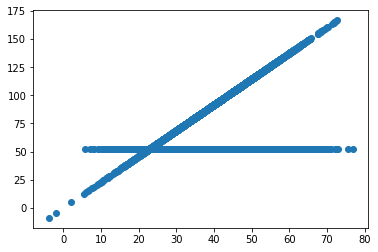

In [3]:
plt.scatter(distances, cost)

In [4]:
def initialize_classic(n_features, mean = 0.0, sd = 1.0):
    betas = {}
    for i in range(2):
        betas[i] = np.random.normal(mean, sd, n_features)
    return(betas)

def initialize_optimal(X, y, delta=0.3):
    n_features = X.shape[0]
    M = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[1]):
        M += y[i]**2 * np.outer(X[:,i], X[:,i])
    M /= X.shape[1]
    
    eigenvalues, eigenvectors = np.linalg.eig(M)
    sorted_eigs = sorted(zip(eigenvalues, eigenvectors), key=lambda x: x[0], reverse=True)
    v1 = sorted_eigs[0][1]
    v2 = sorted_eigs[1][1]
    
    t_vals = np.arange(int(np.ceil(2 * np.pi / delta)) + 1).reshape(1, -1, 1)
    G = v1 * np.cos(delta * t_vals) + v2 * np.sin(delta * t_vals)
    G = G.reshape(-1, X.shape[0])
    min_loss = np.inf
    for u1 in G:
        for u2 in G:
            l1 = y - u1.dot(X)
            l2 = y - u2.dot(X)
            optim_mask = np.abs(l1) < np.abs(l2)
            l1 = l1[optim_mask]
            l2 = l2[~optim_mask]
            loss = np.sum(l1**2) + np.sum(l2**2)
            if loss < min_loss:
                min_loss = loss
                betas = {0:u1, 1:u2}
    return(betas)     
            
def run_EM_iteration(X, y, betas, true_betas):
    n_features = X.shape[0]
    pred0 = X.transpose().dot(betas[0])
    pred1 = X.transpose().dot(betas[1])
    err0 = np.abs(pred0 - y)
    err1 = np.abs(pred1 - y)
    lower_error = (err0 < err1)
    j0_ind = np.where(lower_error)
    j1_ind = np.where(~lower_error)
    X_0 = X[:, j0_ind].reshape(n_features,-1)
    X_1 = X[:,j1_ind].reshape(n_features,-1)
    
    ##Solve least squares 
    try:
        beta_0 = np.linalg.inv(X_0.dot(X_0.transpose())).dot(X_0).dot(y[j0_ind])
    except:
        beta_0 = betas[0]
    
    try:
        beta_1 = np.linalg.inv(X_1.dot(X_1.transpose())).dot(X_1).dot(y[j1_ind])
    except:
        beta_1 = betas[1]
    
    betas = {0: beta_0,
             1: beta_1}
    
    iter_err_0 = np.sum((beta_0.dot(X_0) - y[j0_ind])**2)
    iter_err_1 = np.sum((beta_1.dot(X_1) - y[j1_ind])**2)
    iter_err = np.log(np.sqrt((iter_err_0 + iter_err_1) / X.shape[1])) # log RMSE
    
    iter_beta_err_v1 = max(np.linalg.norm(betas[0] - true_betas[0]), np.linalg.norm(betas[1] - true_betas[1]))
    iter_beta_err_v2 = max(np.linalg.norm(betas[1] - true_betas[0]), np.linalg.norm(betas[0] - true_betas[1]))
    iter_beta_err = np.log(min(iter_beta_err_v1, iter_beta_err_v2))
    if iter_beta_err < -35:
        iter_beta_err = -35

    
    return(betas, iter_err, iter_beta_err)

def fit_mixed_regression(x, y, z, do_normalize = True, n_iter = 10, algo_type = 'classic'):
    n_samples = x.shape[0]
    ones = np.ones(n_samples).reshape(-1, 1)
    if do_normalize:
        x = (x - np.mean(x)) / np.std(x)
        y = (y - np.mean(y)) / np.std(y)
    X = np.concatenate((ones, x), axis = 1).transpose()
    
    #get true betas
    X0 = X[:, (z==0).reshape(-1)]
    X1 = X[:, (z==1).reshape(-1)]
    y0 = y[(z==0).reshape(-1)]
    y1 = y[(z==1).reshape(-1)]
    true_beta_0 = np.linalg.inv(X0.dot(X0.transpose())).dot(X0).dot(y0)
    true_beta_1 = np.linalg.inv(X1.dot(X1.transpose())).dot(X1).dot(y1)
    true_betas = {0: true_beta_0, 1: true_beta_1}
    #initialize parameters
    if algo_type == 'classic':
        betas = initialize_classic(X.shape[0])
    else:
        betas = initialize_optimal(X, y)
    iter_errs = []
    iter_beta_errs = []

    for j in range(n_iter):
        betas, iter_err, iter_beta_err = run_EM_iteration(X, y, betas, true_betas)
        iter_errs.append(iter_err)
        iter_beta_errs.append(iter_beta_err)
    return(betas, iter_errs, iter_beta_errs)

Example of a the algorithm on a single dataset:

In [5]:
np.random.seed(4)
x = np.random.normal(40, 10, size = 10000).reshape(10000, -1)
z = np.random.randint(0, 1+1, size = 10000).reshape(10000, -1)
beta_0 = 52 * z
beta_1 = 2.29 * (1 - z)
error_size = 0
y = beta_0 + x * beta_1 + np.random.normal(0, error_size, 10000).reshape(-1,1)
y = y.reshape(-1)

In [7]:
betas_classic, iter_errs_classic, iter_beta_errs_classic = fit_mixed_regression(x, y, z, do_normalize = False)
betas_opt, iter_errs_opt, iter_beta_errs_opt = fit_mixed_regression(x, y, z, do_normalize = False, algo_type = 'optimal')

betas_classic_n, iter_errs_classic_n, iter_beta_errs_classic_n = fit_mixed_regression(x, y, z, do_normalize = True)
betas_opt_n, iter_errs_opt_n, iter_beta_errs_opt_n = fit_mixed_regression(x, y, z, do_normalize = True, algo_type = 'optimal')

C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


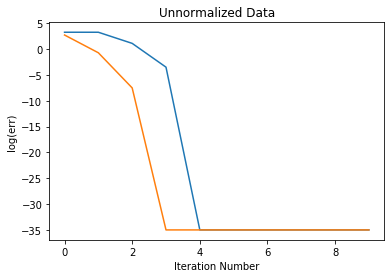

In [8]:
plt.plot(iter_beta_errs_classic, label = 'Classic')
plt.plot(iter_beta_errs_opt, label = 'Optimal')
plt.xlabel('Iteration Number')
plt.ylabel('log(err)')
plt.title('Unnormalized Data')
plt.show()

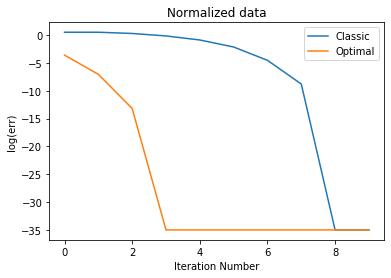

In [9]:
plt.plot(iter_beta_errs_classic_n, label = 'Classic')
plt.plot(iter_beta_errs_opt_n, label = 'Optimal')
plt.xlabel('Iteration Number')
plt.ylabel('log(err)')
plt.title('Normalized data')
plt.legend()
plt.show()

Below we write code to simulate data and run both fitting procedures. We also determine whether a fit converged to the true betas, or if it converged to some other local minimum (or otherwise failed to converge).

In [10]:
def create_trip_data(n_trips, error_size = 0):
    distances = np.random.normal(40, 10, size = 10000).reshape(10000, -1)
    trip_type = np.random.randint(0, 1+1, size = 10000).reshape(10000, -1)
    beta_0 = 52 * trip_type
    beta_1 = 2.29 * (1 - trip_type)
    cost = beta_0 + distances * beta_1 + np.random.normal(0, error_size, 10000).reshape(-1,1)
    cost = cost.reshape(-1)
    return(distances, trip_type, cost)

def create_trip_data_3d(n_trips, error_size = 0):
    distances = np.random.normal(40, 10, size = 10000).reshape(10000, -1)
    tip_amount = np.random.normal(10, 2, size = 10000).reshape(10000, -1)
    trip_type = np.random.randint(0, 1+1, size = 10000).reshape(10000, -1)
    beta_0 = 52 * trip_type 
    beta_1 = 2.29 * (1 - trip_type)
    cost = beta_0 + distances * beta_1 + np.random.normal(0, error_size, 10000).reshape(-1,1) + tip_amount
    cost = cost.reshape(-1)
    features = np.concatenate((distances, tip_amount), axis = 1)
    return(features, trip_type, cost)
    
def simulate_fits(n_trips, error_size, creation_func, n_sims, do_normalize):

    all_iter_errs_classic = []
    all_iter_errs_opt = []
    beta_errs_classic = []
    beta_errs_opt = []
    #all_iter_errs_classic_nolog = []
    #all_iter_errs_opt_nolog = []
    convergence_record_classic = []
    convergence_record_opt = []
    for run_num in range(n_sims):
        features, trip_type, cost = creation_func(n_trips, error_size)
        
        np.random.seed(run_num)
        betas_classic, iter_errs_classic, iter_beta_errs_classic = \
            fit_mixed_regression(features, cost, trip_type, do_normalize = do_normalize, algo_type = 'classic')
        
        betas_opt, iter_errs_opt, iter_beta_errs_opt = \
            fit_mixed_regression(features, cost, trip_type, do_normalize = do_normalize, algo_type = 'optimal')

        #classic_converged = determine_global_convergence(betas_classic)
        #optimal_converged = determine_global_convergence(betas_opt)
        
        all_iter_errs_classic.append(iter_errs_classic)
        all_iter_errs_opt.append(iter_errs_opt)
        beta_errs_classic.append(iter_beta_errs_classic)
        beta_errs_opt.append(iter_beta_errs_opt)
        #all_iter_errs_classic_nolog.append(np.exp(iter_errs_classic))
        #all_iter_errs_opt_nolog.append(np.exp(iter_errs_opt))
        #convergence_record_classic.append(classic_converged)
        #convergence_record_opt.append(optimal_converged)
        
    
    #all_iter_errs_classic = np.array(all_iter_errs_classic)
    #all_iter_errs_opt = np.array(all_iter_errs_opt)
    beta_errs_classic = np.array(beta_errs_classic)
    beta_errs_opt = np.array(beta_errs_opt)
    #avg_errs_classic = np.mean(all_iter_errs_classic, axis = 0)
    #avg_errs_opt = np.mean(all_iter_errs_opt, axis = 0)
    avg_beta_errs_classic = np.mean(beta_errs_classic, axis = 0)
    avg_beta_errs_opt = np.mean(beta_errs_opt, axis = 0)
    #avg_errs_classic_nolog = np.mean(all_iter_errs_classic_nolog, axis = 0)
    #avg_errs_opt_nolog = np.mean(all_iter_errs_opt_nolog, axis = 0)
    #classic_convergence_rate = np.mean(np.array(convergence_record_classic))
    #optimal_convergence_rate = np.mean(np.array(convergence_record_opt))
    
    #print('Random initialization converged to true parameters with frequency ' + \
          #str(classic_convergence_rate))
    #print('Improved initialization converged to true parameters with frequency ' + \
          #str(optimal_convergence_rate))
    
   # plt.plot(avg_errs_classic, label = 'Classic')
   # plt.plot(avg_errs_opt, label = 'Optimal')
   # plt.title('Average of log')
   # plt.legend()
    #plt.show()
    
    #plt.plot(np.log(avg_errs_classic_nolog), label = 'Classic')
    #plt.plot(np.log(avg_errs_opt_nolog), label = 'Optimal')
    #plt.title('Log of average')
    #plt.legend()
    
    plt.plot(avg_beta_errs_classic, label = 'Classic')
    plt.plot(avg_beta_errs_opt, label = 'Optimal')
    plt.title('Average log parameter error')
    plt.legend()
    plt.show()

Below, we run simulations for all combinations of three binary situations:
    1. Whether or not we normalize the features and response before training.
    2. Whether or not we inject normally distributed noise (stddev = 3) to the response.
    3. Whether we simulate 2-d data or 3-d data.

C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


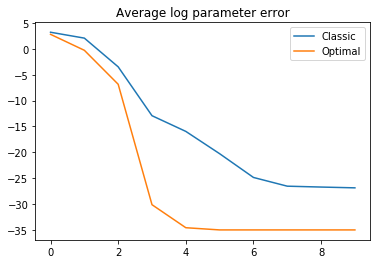

In [11]:
simulate_fits(n_trips = 10000, error_size = 0, creation_func = create_trip_data, n_sims = 200, do_normalize = False)

C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


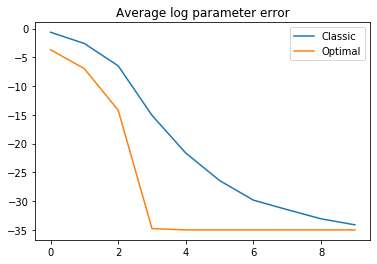

In [12]:
simulate_fits(n_trips = 10000, error_size = 0, creation_func = create_trip_data, n_sims = 200, do_normalize = True)

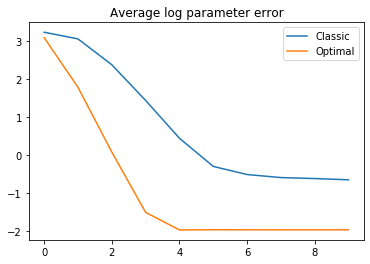

In [13]:
simulate_fits(n_trips = 10000, error_size = 3, creation_func = create_trip_data, n_sims = 200, do_normalize = False)

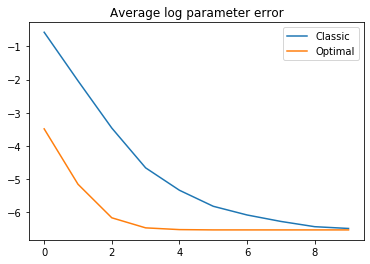

In [14]:
simulate_fits(n_trips = 10000, error_size = 3, creation_func = create_trip_data, n_sims = 200, do_normalize = True)

C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


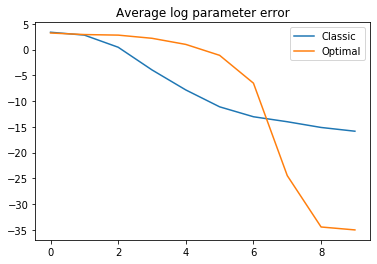

In [15]:
simulate_fits(n_trips = 10000, error_size = 0, creation_func = create_trip_data_3d, n_sims = 200, do_normalize = False)

C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


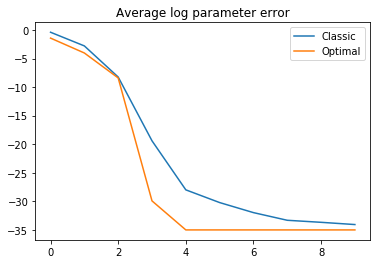

In [16]:
simulate_fits(n_trips = 10000, error_size = 0, creation_func = create_trip_data_3d, n_sims = 200, do_normalize = True)

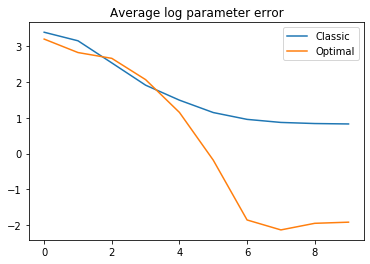

In [17]:
simulate_fits(n_trips = 10000, error_size = 3, creation_func = create_trip_data_3d, n_sims = 200, do_normalize = False)

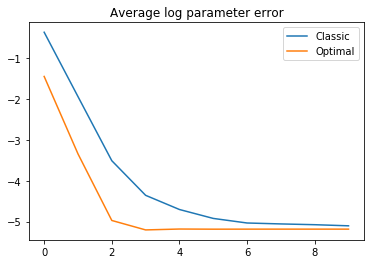

In [18]:
simulate_fits(n_trips = 10000, error_size = 3, creation_func = create_trip_data_3d, n_sims = 200, do_normalize = True)

Everything after this is scratch work

In [ ]:
example_dist, _, example_cost = create_trip_data(10000, error_size = 3)
plt.scatter(example_dist, example_cost)

Note that both methods converge to the true parameters much less frequently. This is a little misleading. Because we've injected noise, the OLS solutions won't match the true betas exactly, even if we can guess the latent classes perfectly. It might be better to see if the fits converge to the correct OLS solutions.

In [ ]:
simulate_fits(n_trips = 10000, error_size = 3, n_sims = 200)

In [ ]:
green = pd.read_csv('green19.csv')
green_small = green.query('trip_distance > 0 & trip_distance  <=100 & \
                    total_amount > 0 & total_amount <= 200 & \
                    (RatecodeID == 1 | RatecodeID == 2)')
green_small = green_small.filter(items = ['RatecodeID', 'trip_distance', 'fare_amount'])
green_small.head()

In [ ]:
plt.scatter(green_small.trip_distance[green_small.RatecodeID==1], green_small.fare_amount[green_small.RatecodeID==1])

In [ ]:
plt.scatter(green_small.trip_distance[green_small.RatecodeID==2], green_small.fare_amount[green_small.RatecodeID==2])

In [ ]:
np.random.seed(1)
betas, iter_errs_classic = fit_mixed_regression(np.array(green_small.trip_distance),
                                                np.array(green_small.fare_amount), 
                                                algo_type = 'classic')
betas_opt, iter_errs_opt = fit_mixed_regression(np.array(green_small.trip_distance),
                                                np.array(green_small.fare_amount),
                                                algo_type = 'optimal')

In [ ]:
betas

In [ ]:
betas_opt

In [ ]:
plt.plot(iter_errs_classic)
plt.xlabel('Iteration Number')
plt.ylabel('log(RMSE)')
plt.title('Random initialization for mixed regression')
plt.show()

plt.plot(iter_errs_opt)
plt.xlabel('Iteration Number')
plt.ylabel('log(RMSE)')
plt.title('Optimal initialization for mixed regression')
plt.show()